# GCM Filters Tutorial

## Synthetic Data

In this example, we are going to work with "synthetic data"; data we made up for the sake of keeping the example simple and self-contained.

### Create Input Data

Gcm-filters uses Xarray DataArrays for its inputs and outputs. So we will first import xarray (and numpy).

In [1]:
import gcm_filters
import numpy as np
import xarray as xr

Now we will create a random 3D cube of data.

In [2]:
nt, ny, nx = (10, 128, 256)
data = np.random.rand(nt, ny, nx)
da = xr.DataArray(data, dims=['time', 'y', 'x'])
da

<xarray.DataArray (time: 10, y: 128, x: 256)>
array([[[0.35465512, 0.97200594, 0.13611624, ..., 0.78735905,
         0.85423537, 0.84189582],
        [0.79240943, 0.4775985 , 0.47724304, ..., 0.56782151,
         0.59549969, 0.1053518 ],
        [0.57733862, 0.66048301, 0.56851068, ..., 0.19020767,
         0.14067169, 0.27171096],
        ...,
        [0.61415601, 0.32310242, 0.9882926 , ..., 0.3504414 ,
         0.51140689, 0.32373513],
        [0.7643417 , 0.57783639, 0.81701088, ..., 0.82466368,
         0.00143445, 0.63987571],
        [0.48037046, 0.37185157, 0.51841169, ..., 0.58262102,
         0.41612379, 0.45808513]],

       [[0.46697787, 0.42856056, 0.37576538, ..., 0.34525044,
         0.81833807, 0.11907149],
        [0.70129605, 0.87015278, 0.09110398, ..., 0.58767235,
         0.42980006, 0.08095235],
        [0.01840666, 0.17232892, 0.63498795, ..., 0.5649966 ,
         0.17478774, 0.08434836],
...
        [0.8549476 , 0.93655918, 0.83740306, ..., 0.54282732,
         0.64217657, 0.05607217],
        [0.56607594, 0.24973102, 0.637557  , ..., 0.63219676,
         0.79156444, 0.69467296],
        [0.50031088, 0.95247847, 0.69425136, ..., 0.14136329,
         0.17349384, 0.44457615]],

       [[0.3288639 , 0.17308488, 0.8601216 , ..., 0.21530271,
         0.63338362, 0.7852744 ],
        [0.65445055, 0.66832114, 0.5927022 , ..., 0.16429199,
         0.16918704, 0.50102837],
        [0.41151733, 0.38789761, 0.2331703 , ..., 0.81107977,
         0.13896245, 0.19969136],
        ...,
        [0.86026637, 0.81696272, 0.59197368, ..., 0.30807527,
         0.37791543, 0.59068587],
        [0.59863705, 0.4032838 , 0.08840804, ..., 0.8285281 ,
         0.85719792, 0.65468291],
        [0.37486887, 0.83663067, 0.691618  , ..., 0.33628028,
         0.93787455, 0.64841767]]])
Dimensions without coordinates: time, y, x

To make things a bit more interesting, we will create a "land mask"; a binary array representing topography in our made-up ocean.
The convention here is that the array is 1 in the ocean ("wet points") and 0 in the land ("dry points").

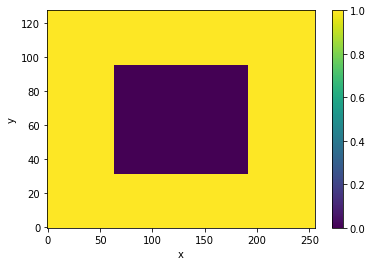

In [3]:
mask_data = np.ones((ny, nx))
mask_data[(ny // 4):(3 * ny // 4), (nx // 4):(3 * nx // 4)] = 0
wet_mask = xr.DataArray(mask_data, dims=['y', 'x'])
wet_mask.plot()

We have made a big island.
We now use this to mask our data.

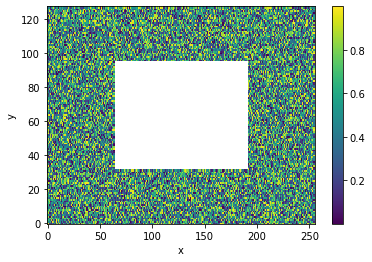

In [4]:
da_masked = da.where(wet_mask)
da_masked[0].plot()

### Create a Filter

The main class we use from gcm-filters is the {class}`gcm_filters.Filter` object.
When we create a filter, we specify how we want to smooth the data, including the filter shape and all the relevant parameters.

To define a filter, we need to pick a few options from the predefined lists of filter shapes and grid types.

The possible filter shapes are enumerated as follows:

In [5]:
list(gcm_filters.FilterShape)

[<FilterShape.GAUSSIAN: 1>, <FilterShape.TAPER: 2>]

The possible grid types are:

In [6]:
list(gcm_filters.GridType)

[<GridType.REGULAR: 1>,
 <GridType.TRANSFORMED_TO_REGULAR: 2>,
 <GridType.REGULAR_WITH_LAND: 3>,
 <GridType.TRANSFORMED_TO_REGULAR_WITH_LAND: 4>,
 <GridType.IRREGULAR_WITH_LAND: 5>,
 <GridType.TRIPOLAR_TRANSFORMED_TO_REGULAR_WITH_LAND: 6>,
 <GridType.TRIPOLAR_POP_WITH_LAND: 7>,
 <GridType.VECTOR_C_GRID: 8>]

(This list will grow as we implement more Laplacians).

For now, we will choose `REGULAR_WITH_LAND`, which matches our synthetic data.
Each grid type has different "grid variables" that must be provided.
To find out what these are, we can use this utility function.

In [7]:
gcm_filters.required_grid_vars(gcm_filters.GridType.REGULAR_WITH_LAND)

['wet_mask']

So if we use this grid type, we have to include a `wet_mask` grid variable.

We are now ready to create our filter object.

In [9]:
filter = gcm_filters.Filter(
    filter_scale=4,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.TAPER,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)
filter

Filter(filter_scale=4, dx_min=1, filter_shape=<FilterShape.TAPER: 2>, transition_width=3.141592653589793, ndim=2, n_steps=16, grid_type=<GridType.REGULAR_WITH_LAND: 3>)

The repr (i.e., the string representation) for the filter object includes some of the parameters it was initiliazed with, to help us keep track of what we are doing.

Next we plot the shape of the target filter and the approximation. Note that this is not the shape of the filter *kernel*. Rather, it shows the frequency response of the filter, meaning that we're plotting how the filter attenuates different scales in the data. The filter is 1 at large scales (small wavenumbers $k$, at the left side of the plot) and 0 at small scales (large wavenumbers $k$, at the right side of the plot), meaning that large scales are left unchanged and small scales are damped to zero.

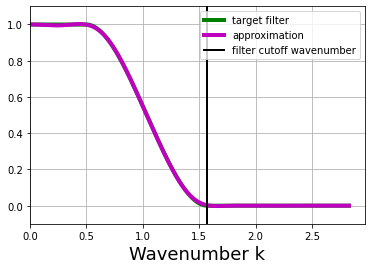

In [10]:
filter.plot_shape()

By not specifying `n_steps`, we allow the filter to automatically select a value that leads to a very-good approximation of the target. In the above example using the Taper shape, the filter elects to use 16 steps to filter by a factor of 4.

The user might want to use a smaller number of steps to reduce the cost. The caveat is that the accuracy will be reduced, so the filter might not act as expected. To illustrate, we create a new filter with a smaller number of steps and plot the result. (Note that using a value of `n_steps` lower than the default will raise a warning.)

/glade/u/home/noraloose/gcm-filters/gcm_filters/filter.py:11: UserWarning: You have set n_steps below the default. Results might not be accurate.
  


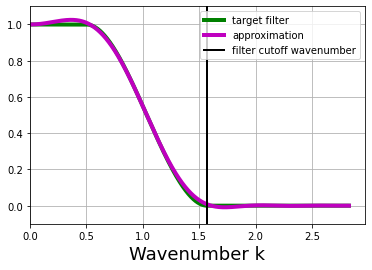

In [12]:
filter_8 = gcm_filters.Filter(
    filter_scale=4,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.TAPER,
    n_steps=8,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)
filter_8.plot_shape()

The example above shows that using `n_steps=8` still yields a very accurate approximation of the target filter, at half the cost of the default. The main drawback in this example is that the filter slightly *amplifies* large scales, which also implies that it will not conserve variance. 

Below we show what happens with `n_steps=4`. For this example of a Taper filter with a filter factor of 4, `n_steps=4` is simply not enough to get a good approximation of the target filter. The `filter_4` object created here will still "work" but it will not behave as expected; specifically, it will smooth more than expected - it will act like a filter with a larger filter scale.

/glade/u/home/noraloose/gcm-filters/gcm_filters/filter.py:11: UserWarning: You have set n_steps below the default. Results might not be accurate.
  


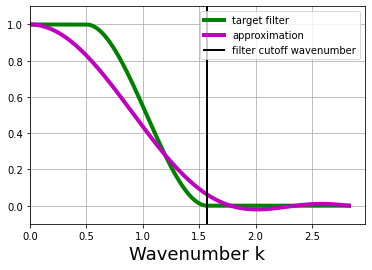

In [13]:
filter_4 = gcm_filters.Filter(
    filter_scale=4,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.TAPER,
    n_steps=4,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)
filter_4.plot_shape()

In [14]:
del filter_8, filter_4

### Apply the Filter

Now that we have our filter defined, we can use it on some data. We need to specify which dimension names to apply the filter over. In this case, it is y, x.

In [15]:
%time da_filtered = filter.apply(da_masked, dims=['y', 'x'])
da_filtered

CPU times: user 88.5 ms, sys: 30.9 ms, total: 119 ms
Wall time: 123 ms


<xarray.DataArray (time: 10, y: 128, x: 256)>
array([[[0.54809688, 0.51879934, 0.45514536, ..., 0.54077783,
         0.54456105, 0.54726763],
        [0.51027425, 0.50829846, 0.47952886, ..., 0.50617368,
         0.49433087, 0.49501071],
        [0.46562662, 0.48901278, 0.49296147, ..., 0.48759978,
         0.45046558, 0.44113049],
        ...,
        [0.45416375, 0.50135563, 0.50022922, ..., 0.5021761 ,
         0.43741638, 0.41562048],
        [0.50440694, 0.50890034, 0.46730875, ..., 0.5304542 ,
         0.49895897, 0.4870923 ],
        [0.54747542, 0.51843947, 0.44854823, ..., 0.55195339,
         0.54888113, 0.54681858]],

       [[0.40788693, 0.42562273, 0.45773465, ..., 0.52748649,
         0.47758809, 0.42671061],
        [0.36856905, 0.41450383, 0.45445759, ..., 0.48377584,
         0.4111449 , 0.36218142],
        [0.35718669, 0.42677321, 0.47436382, ..., 0.43942581,
         0.3617547 , 0.32560637],
...
        [0.60642019, 0.62574808, 0.62237682, ..., 0.46241346,
         0.51060521, 0.56372545],
        [0.58849856, 0.6271481 , 0.63239052, ..., 0.44797544,
         0.48021383, 0.53201329],
        [0.54100755, 0.58573353, 0.59717044, ..., 0.46130668,
         0.46130901, 0.49061944]],

       [[0.53729698, 0.52857762, 0.51383054, ..., 0.41468917,
         0.46738022, 0.5187807 ],
        [0.50018455, 0.53593744, 0.54907511, ..., 0.39134667,
         0.41190293, 0.45472288],
        [0.50622026, 0.57975014, 0.61671331, ..., 0.40862194,
         0.40055473, 0.43683165],
        ...,
        [0.57293942, 0.51371839, 0.51298786, ..., 0.50467932,
         0.57709032, 0.61065355],
        [0.60624125, 0.55069431, 0.53122392, ..., 0.49139126,
         0.57548905, 0.62723903],
        [0.58699326, 0.54542774, 0.51721811, ..., 0.45694501,
         0.53387825, 0.59084717]]])
Dimensions without coordinates: time, y, x

Let's visualize what the filter did:

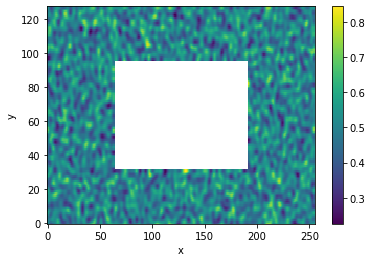

In [16]:
da_filtered[0].plot()

It can be useful to know where the land mask has influenced our results--for example, for assessing commutativity of the filter with differential operators.
We can get at this by applying the filter to the land mask itself.
We will create a new filter object that ignores the land.

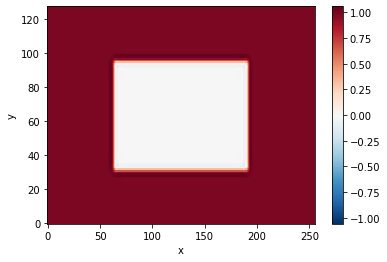

In [18]:
filter_noland = gcm_filters.Filter(
    filter_scale=4,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.TAPER,
    grid_type=gcm_filters.GridType.REGULAR,
    grid_vars={}
)

mask_filtered = filter_noland.apply(wet_mask, dims=['y', 'x'])
mask_filtered.plot()

### Use Dask

Up to now, we have operated "eagerly"; when we called `.apply`, the results were computed immediately and stored in memory.

Gcm-filters is also designed to work seamlessly with Dask array inputs, deferring its computations and possibly executing it in parallel.
We can do this with our synthetic data by converting it to dask.

In [19]:
da_dask = da_masked.chunk({'time': 2})
da_dask

<xarray.DataArray (time: 10, y: 128, x: 256)>
dask.array<xarray-<this-array>, shape=(10, 128, 256), dtype=float64, chunksize=(2, 128, 256), chunktype=numpy.ndarray>
Dimensions without coordinates: time, y, x

In [20]:
da_filtered_lazy = filter.apply(da_dask, dims=['y', 'x'])
da_filtered_lazy

<xarray.DataArray (time: 10, y: 128, x: 256)>
dask.array<transpose, shape=(10, 128, 256), dtype=float64, chunksize=(2, 128, 256), chunktype=numpy.ndarray>
Dimensions without coordinates: time, y, x

Nothing has actually been computed yet.
We can trigger computation as follows:

In [21]:
%time da_filtered_computed = da_filtered_lazy.compute()

CPU times: user 77.9 ms, sys: 3.74 ms, total: 81.7 ms
Wall time: 86 ms


Here we got a very modest speedup because the computation was run in parallel on a four-core laptop.
Our example data are not big enough, and our computer not powerful enough, to really see a big performance benefit here.
But it works!